In [54]:
import pandas as pd, numpy as np, matplotlib.pyplot as plt, seaborn as sns, warnings, sklearn
warnings.filterwarnings('ignore')
AI_COLORS = {'primary':'#8FBC8F','gold':'#DAA520','crypto':'#FF6347','accent':'#6B8E23','highlight':'#ADFF2F','dark':'#2F4F2F','neutral':'#F0FFF0'}
kiwi_palette = [AI_COLORS['primary'], AI_COLORS['gold'], AI_COLORS['crypto'], AI_COLORS['accent'], AI_COLORS['highlight']]
plt.style.use('default')
sns.set_style("whitegrid")
sns.set_palette(kiwi_palette)
plt.rcParams.update({'figure.facecolor':AI_COLORS['neutral'],'figure.figsize':[12,8],'axes.facecolor':'white','axes.edgecolor':AI_COLORS['dark'],'axes.grid':True,'axes.titlecolor':AI_COLORS['dark'],'axes.titleweight':'bold','axes.titlesize':16,'axes.labelsize':12,'grid.color':AI_COLORS['primary'],'grid.alpha':0.3,'font.size':11,'xtick.color':AI_COLORS['dark'],'ytick.color':AI_COLORS['dark'],'legend.fontsize':10,'legend.frameon':True,'legend.facecolor':'white','legend.edgecolor':AI_COLORS['primary'],'lines.linewidth':2,'savefig.dpi':300,'savefig.bbox':'tight'})
sns.set_context("notebook", font_scale=1.1)

# The Problem

Computation and automation has absolutely taken over the trading world. As a retail trader, your best bet is to bet on what the automated trades will think, not what YOU actually think will happen. This puts you at a massive disadvantage and completely changes the way you have to approach the markets as a retail trader.

**The problem is: Can we predict the next 15-minute period return of the S&P 500?**

We will use regression to predict the continuous return value: `next_return = Close(t+1) / Close(t) - 1`

This would help identify profitable entry and exit points for trading.

<hr>

# The Data

The quality of the data is absolutely crucial when predicting the market. Thats why instead of like last time where I built my own data set with a lot of preprocessing I opted to pay for a high quality financially sound source. Backtestmarket. This data is a snap shot of the S&P 500 every 15 minutes, giving enough data to reconstruct the candlestick you would see visually with your eyes, but in memory.

S&P 500 15m: https://www.backtestmarket.com/en/sp-500-15m

Has open high low close volume in increments of 25 cent

## Data explanation
Open: The price at which the S&P 500 opened for the 15 minute interval
Close: The price at which the S&P 500 closed for the 15 minute interval
High: The highest price during the 15 minute interval
Low: The lowest price during the 15 minute interval
Volume: The total volume of trades during the 15 minute interval

<hr>

# Preprocessing

First I want to import the data of course. But while im at it, ill go ahead and cleanup it's formating be a dataframe I like. I will also take care of the date column making it a real datetime object and a single column for the index.

In [55]:
raw_df = pd.read_csv('es-15m.csv')
raw_df.head()

,01/04/2007;17:15:00;1430;1431;1429.75;1431;592
0,01/04/2007;17:30:00;1431;1431.5;1430.75;1430.7...
1,01/04/2007;17:45:00;1430.5;1431;1430.25;1430.5...
2,01/04/2007;18:00:00;1430.5;1430.75;1430.25;143...
3,01/04/2007;18:15:00;1431;1432;1431;1431.25;561
4,01/04/2007;18:30:00;1431;1431.25;1431;1431.25;80


In [56]:
data_split = raw_df.iloc[:, 0].str.split(';', expand=True)
spx_df = pd.DataFrame({
    'Date': data_split[0],
    'Time': data_split[1],
    'Open': pd.to_numeric(data_split[2]),
    'High': pd.to_numeric(data_split[3]),
    'Low': pd.to_numeric(data_split[4]),
    'Close': pd.to_numeric(data_split[5]),
    'Volume': pd.to_numeric(data_split[6])
})

# Create datetime column for index
spx_df['DateTime'] = pd.to_datetime(spx_df['Date'] + ' ' + spx_df['Time'], format='%d/%m/%Y %H:%M:%S')
spx_df = spx_df.set_index('DateTime').sort_index()

# Drop original date/time columns
spx_df = spx_df.drop(['Date', 'Time'], axis=1)
spx_df.head()

,Open,High,Low,Close,Volume
DateTime,,,,,
2007-04-01 17:30:00,1431.0,1431.50,1430.75,1430.75,461
2007-04-01 17:45:00,1430.5,1431.00,1430.25,1430.50,264
2007-04-01 18:00:00,1430.5,1430.75,1430.25,1430.75,91
2007-04-01 18:15:00,1431.0,1432.00,1431.00,1431.25,561
2007-04-01 18:30:00,1431.0,1431.25,1431.00,1431.25,80


Now that we have a clean dataset, we can start engineering features to predict next period returns.

**Target Variable:** `next_return = Close(t+1) / Close(t) - 1`

**Features to engineer:**
1. Returns & Momentum: current and lagged returns
2. Rolling Statistics: mean, std for trend strength
3. RSI: overbought/oversold indicators
4. MACD: trend momentum
5. Volume metrics: changes and z-scores
6. Candlestick features: body, wicks, range
7. Volatility measures

In [57]:
# Target: Next period return
spx_df['next_return'] = spx_df['Close'].shift(-1) / spx_df['Close'] - 1

# Price features
spx_df['return'] = spx_df['Close'].pct_change()
spx_df['return_lag1'] = spx_df['return'].shift(1)
spx_df['return_lag2'] = spx_df['return'].shift(2)
spx_df['log_return'] = np.log(spx_df['Close'] / spx_df['Close'].shift(1))

# Candlestick features
spx_df['body'] = spx_df['Close'] - spx_df['Open']
spx_df['body_pct'] = spx_df['body'] / spx_df['Open']
spx_df['upper_wick'] = spx_df['High'] - spx_df[['Open','Close']].max(axis=1)
spx_df['lower_wick'] = spx_df[['Open','Close']].min(axis=1) - spx_df['Low']
spx_df['range'] = spx_df['High'] - spx_df['Low']
spx_df['range_pct'] = spx_df['range'] / spx_df['Close']

# Rolling statistics
for window in [5, 10, 20]:
    spx_df[f'sma_{window}'] = spx_df['Close'].rolling(window).mean()
    spx_df[f'std_{window}'] = spx_df['Close'].rolling(window).std()
    spx_df[f'price_to_sma_{window}'] = spx_df['Close'] / spx_df[f'sma_{window}'] - 1

# RSI
def calculate_rsi(prices, window=14):
    delta = prices.diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=window).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=window).mean()
    rs = gain / (loss + 1e-9)
    return 100 - (100 / (1 + rs))

spx_df['rsi_14'] = calculate_rsi(spx_df['Close'], 14)

# MACD
ema_12 = spx_df['Close'].ewm(span=12).mean()
ema_26 = spx_df['Close'].ewm(span=26).mean()
spx_df['macd'] = ema_12 - ema_26
spx_df['macd_signal'] = spx_df['macd'].ewm(span=9).mean()
spx_df['macd_diff'] = spx_df['macd'] - spx_df['macd_signal']

# Volume features
spx_df['vol_chg'] = spx_df['Volume'].pct_change()
spx_df['vol_sma_20'] = spx_df['Volume'].rolling(20).mean()
spx_df['vol_std_20'] = spx_df['Volume'].rolling(20).std()
spx_df['vol_zscore'] = (spx_df['Volume'] - spx_df['vol_sma_20']) / (spx_df['vol_std_20'] + 1e-9)

# Momentum
spx_df['momentum_3'] = spx_df['Close'] - spx_df['Close'].shift(3)
spx_df['momentum_5'] = spx_df['Close'] - spx_df['Close'].shift(5)

spx_df = spx_df.dropna()

print(f"Dataset shape: {spx_df.shape}")
print(f"Target (next_return) stats:")
print(f"  Mean: {spx_df['next_return'].mean():.6f}")
print(f"  Std: {spx_df['next_return'].std():.6f}")
print(f"  Min: {spx_df['next_return'].min():.6f}")
print(f"  Max: {spx_df['next_return'].max():.6f}")

Dataset shape: (435183, 35)
Target (next_return) stats:
  Mean: 0.000004
  Std: 0.001288
  Min: -0.043162
  Max: 0.042909


# Exploration

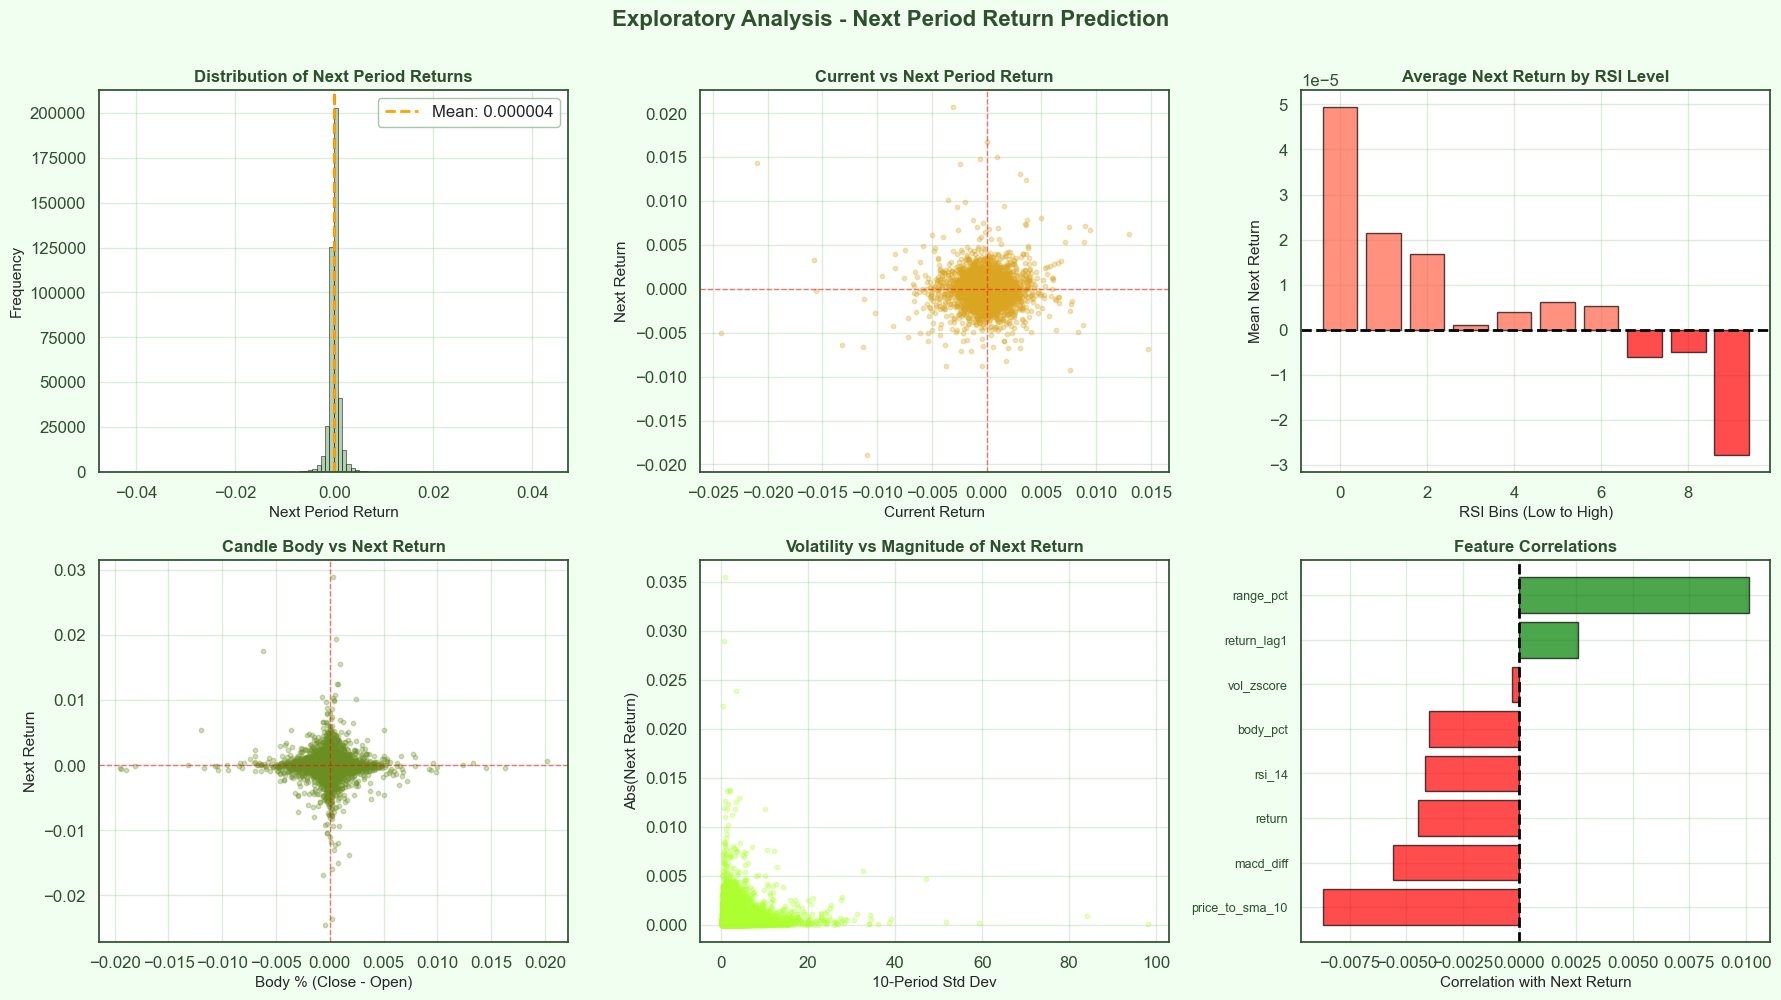

In [58]:
# Exploration: Return Prediction Analysis

fig, axes = plt.subplots(2, 3, figsize=(18, 10))

# 1. Target distribution
axes[0, 0].hist(spx_df['next_return'], bins=100, color=AI_COLORS['primary'], 
               alpha=0.7, edgecolor='black', linewidth=0.5)
axes[0, 0].axvline(0, color='red', linestyle='--', linewidth=2)
axes[0, 0].axvline(spx_df['next_return'].mean(), color='orange', linestyle='--', linewidth=2, 
                  label=f"Mean: {spx_df['next_return'].mean():.6f}")
axes[0, 0].set_xlabel('Next Period Return', fontsize=11)
axes[0, 0].set_ylabel('Frequency', fontsize=11)
axes[0, 0].set_title('Distribution of Next Period Returns', fontsize=12, fontweight='bold')
axes[0, 0].legend()
axes[0, 0].grid(alpha=0.3)

# 2. Current return vs next return
sample = spx_df[['return', 'next_return']].sample(min(10000, len(spx_df)))
axes[0, 1].scatter(sample['return'], sample['next_return'], alpha=0.3, s=10, color=AI_COLORS['gold'])
axes[0, 1].axhline(0, color='red', linestyle='--', linewidth=1, alpha=0.5)
axes[0, 1].axvline(0, color='red', linestyle='--', linewidth=1, alpha=0.5)
axes[0, 1].set_xlabel('Current Return', fontsize=11)
axes[0, 1].set_ylabel('Next Return', fontsize=11)
axes[0, 1].set_title('Current vs Next Period Return', fontsize=12, fontweight='bold')
axes[0, 1].grid(alpha=0.3)

# 3. RSI vs next return
rsi_bins = pd.cut(spx_df['rsi_14'], bins=10)
returns_by_rsi = spx_df.groupby(rsi_bins)['next_return'].mean()
axes[0, 2].bar(range(len(returns_by_rsi)), returns_by_rsi.values,
              color=[AI_COLORS['crypto'] if x > 0 else 'red' for x in returns_by_rsi.values],
              alpha=0.7, edgecolor='black')
axes[0, 2].axhline(0, color='black', linestyle='--', linewidth=2)
axes[0, 2].set_xlabel('RSI Bins (Low to High)', fontsize=11)
axes[0, 2].set_ylabel('Mean Next Return', fontsize=11)
axes[0, 2].set_title('Average Next Return by RSI Level', fontsize=12, fontweight='bold')
axes[0, 2].grid(axis='y', alpha=0.3)

# 4. Body vs next return
axes[1, 0].scatter(spx_df['body_pct'].sample(min(10000, len(spx_df))), 
                  spx_df['next_return'].sample(min(10000, len(spx_df))),
                  alpha=0.3, s=10, color=AI_COLORS['accent'])
axes[1, 0].axhline(0, color='red', linestyle='--', linewidth=1, alpha=0.5)
axes[1, 0].axvline(0, color='red', linestyle='--', linewidth=1, alpha=0.5)
axes[1, 0].set_xlabel('Body % (Close - Open)', fontsize=11)
axes[1, 0].set_ylabel('Next Return', fontsize=11)
axes[1, 0].set_title('Candle Body vs Next Return', fontsize=12, fontweight='bold')
axes[1, 0].grid(alpha=0.3)

# 5. Volatility vs abs(next return)
axes[1, 1].scatter(spx_df['std_10'].sample(min(10000, len(spx_df))), 
                  abs(spx_df['next_return']).sample(min(10000, len(spx_df))),
                  alpha=0.3, s=10, color=AI_COLORS['highlight'])
axes[1, 1].set_xlabel('10-Period Std Dev', fontsize=11)
axes[1, 1].set_ylabel('Abs(Next Return)', fontsize=11)
axes[1, 1].set_title('Volatility vs Magnitude of Next Return', fontsize=12, fontweight='bold')
axes[1, 1].grid(alpha=0.3)

# 6. Feature correlation with target
feature_cols = ['return', 'return_lag1', 'rsi_14', 'macd_diff', 'vol_zscore', 
                'body_pct', 'range_pct', 'price_to_sma_10']
correlations = spx_df[feature_cols + ['next_return']].corr()['next_return'].drop('next_return').sort_values()
colors = ['green' if x > 0 else 'red' for x in correlations.values]
axes[1, 2].barh(range(len(correlations)), correlations.values, color=colors, alpha=0.7, edgecolor='black')
axes[1, 2].set_yticks(range(len(correlations)))
axes[1, 2].set_yticklabels(correlations.index, fontsize=9)
axes[1, 2].axvline(0, color='black', linestyle='--', linewidth=2)
axes[1, 2].set_xlabel('Correlation with Next Return', fontsize=11)
axes[1, 2].set_title('Feature Correlations', fontsize=12, fontweight='bold')
axes[1, 2].grid(axis='x', alpha=0.3)

plt.suptitle('Exploratory Analysis - Next Period Return Prediction', 
            fontsize=16, fontweight='bold', color=AI_COLORS['dark'], y=1.00)
plt.tight_layout()
plt.show()

# Modeling

## Ridge Regression (L2 Regularization)

In [59]:
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Select features
features = ['return', 'return_lag1', 'return_lag2', 'log_return',
            'body_pct', 'upper_wick', 'lower_wick', 'range_pct',
            'price_to_sma_5', 'price_to_sma_10', 'price_to_sma_20',
            'rsi_14', 'macd_diff', 'vol_zscore', 'vol_chg',
            'momentum_3', 'momentum_5']

X = spx_df[features]
y = spx_df['next_return']

# Train/test split (time-series aware)
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(
    X, y, test_size=0.2, shuffle=False
)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train Ridge regression
model = Ridge(alpha=1.0)
model.fit(X_train_scaled, y_train)
preds = model.predict(X_test_scaled)

# Evaluate
mse = mean_squared_error(y_test, preds)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, preds)
r2 = r2_score(y_test, preds)

print("="*70)
print("RIDGE REGRESSION PERFORMANCE")
print("="*70)
print(f"Mean Squared Error (MSE):  {mse:.8f}")
print(f"Root Mean Squared Error:   {rmse:.8f}")
print(f"Mean Absolute Error (MAE): {mae:.8f}")
print(f"R² Score:                  {r2:.6f}")
print(f"\nTarget Stats:")
print(f"  Mean:  {y_test.mean():.8f}")
print(f"  Std:   {y_test.std():.8f}")

# Feature importance
feature_importance = pd.DataFrame({
    'Feature': features,
    'Coefficient': model.coef_
}).sort_values('Coefficient', key=abs, ascending=False)

print("\n" + "="*70)
print("TOP 10 MOST IMPORTANT FEATURES")
print("="*70)
print(feature_importance.head(10).to_string(index=False))

RIDGE REGRESSION PERFORMANCE
Mean Squared Error (MSE):  0.00000142
Root Mean Squared Error:   0.00119359
Mean Absolute Error (MAE): 0.00067096
R² Score:                  -0.001245

Target Stats:
  Mean:  0.00000500
  Std:   0.00119286

TOP 10 MOST IMPORTANT FEATURES
        Feature  Coefficient
         return     0.006948
     log_return    -0.006873
 price_to_sma_5    -0.000078
    return_lag1     0.000066
    return_lag2     0.000038
     upper_wick     0.000025
     lower_wick    -0.000023
price_to_sma_10    -0.000013
price_to_sma_20    -0.000012
     momentum_3    -0.000012


## Model Evaluation Visualizations

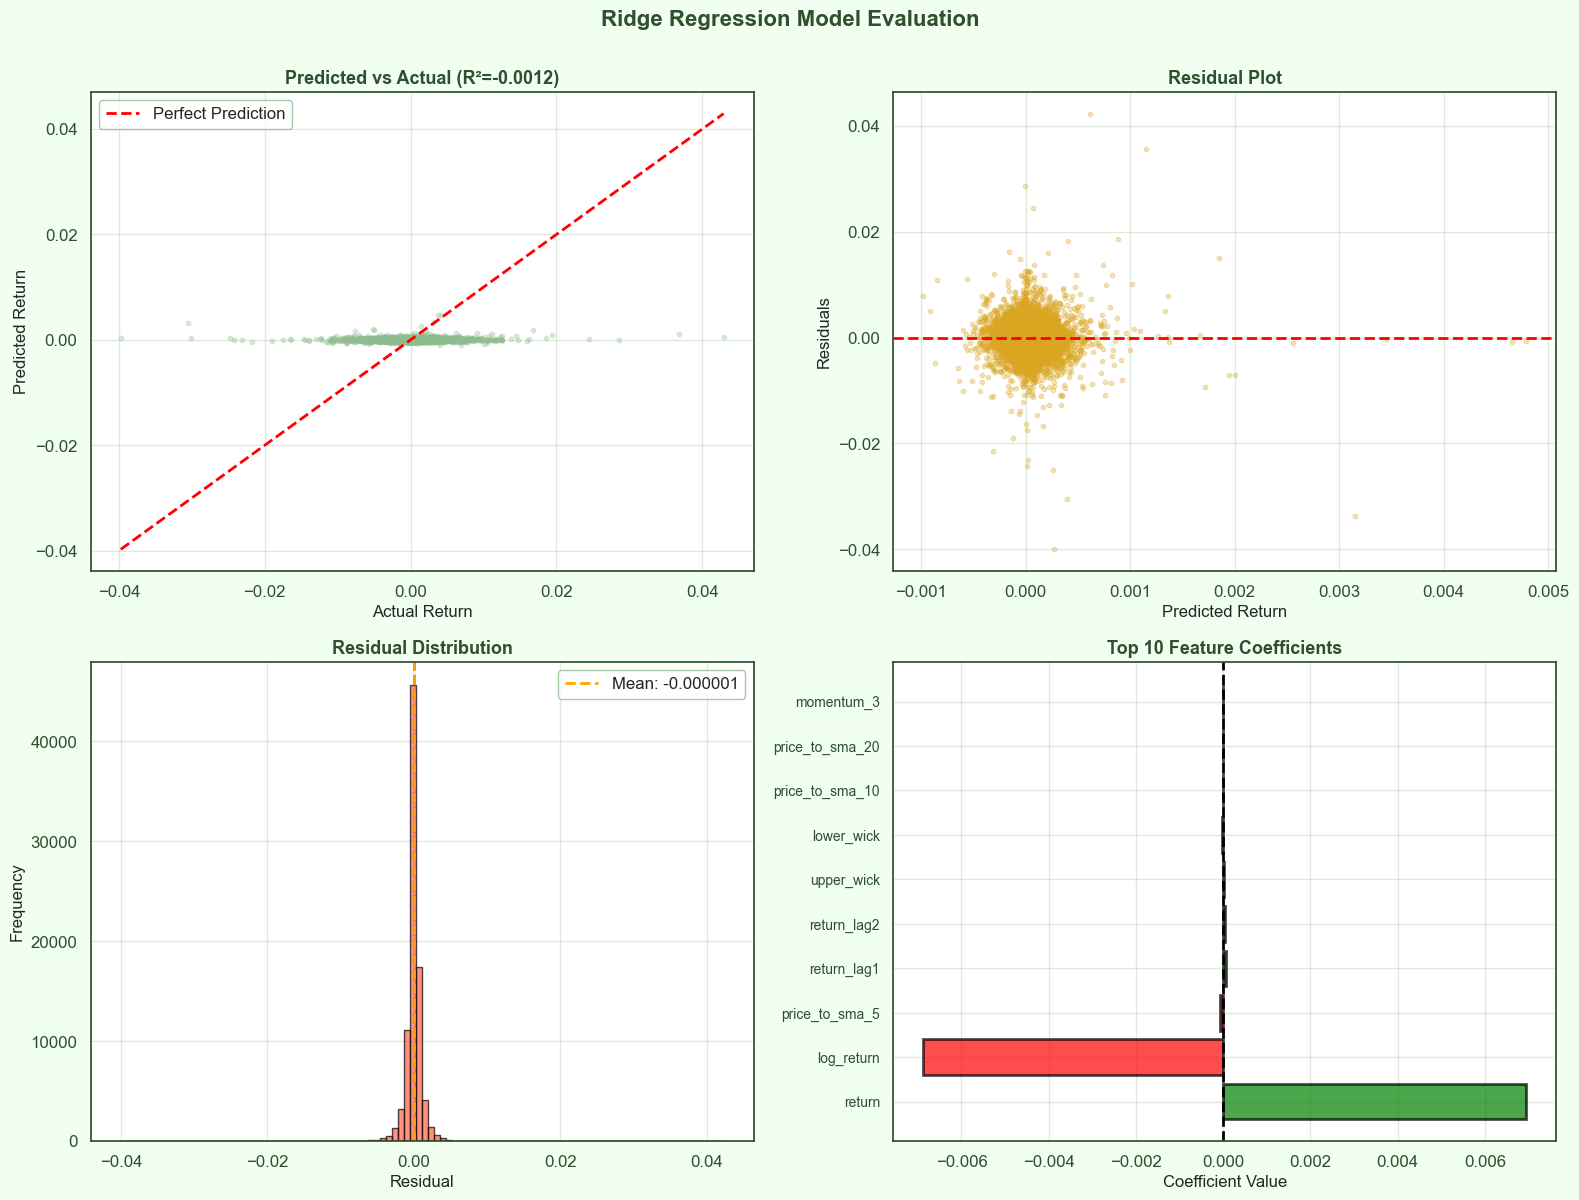

In [60]:
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Predicted vs Actual
axes[0, 0].scatter(y_test, preds, alpha=0.3, s=10, color=AI_COLORS['primary'])
axes[0, 0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 
               'r--', linewidth=2, label='Perfect Prediction')
axes[0, 0].set_xlabel('Actual Return', fontsize=12)
axes[0, 0].set_ylabel('Predicted Return', fontsize=12)
axes[0, 0].set_title(f'Predicted vs Actual (R²={r2:.4f})', fontsize=13, fontweight='bold')
axes[0, 0].legend()
axes[0, 0].grid(alpha=0.3)

# 2. Residuals
residuals = y_test - preds
axes[0, 1].scatter(preds, residuals, alpha=0.3, s=10, color=AI_COLORS['gold'])
axes[0, 1].axhline(0, color='red', linestyle='--', linewidth=2)
axes[0, 1].set_xlabel('Predicted Return', fontsize=12)
axes[0, 1].set_ylabel('Residuals', fontsize=12)
axes[0, 1].set_title('Residual Plot', fontsize=13, fontweight='bold')
axes[0, 1].grid(alpha=0.3)

# 3. Residual distribution
axes[1, 0].hist(residuals, bins=100, color=AI_COLORS['crypto'], alpha=0.7, edgecolor='black')
axes[1, 0].axvline(0, color='red', linestyle='--', linewidth=2)
axes[1, 0].axvline(residuals.mean(), color='orange', linestyle='--', linewidth=2, 
                  label=f'Mean: {residuals.mean():.6f}')
axes[1, 0].set_xlabel('Residual', fontsize=12)
axes[1, 0].set_ylabel('Frequency', fontsize=12)
axes[1, 0].set_title('Residual Distribution', fontsize=13, fontweight='bold')
axes[1, 0].legend()
axes[1, 0].grid(alpha=0.3)

# 4. Feature importance
top_features = feature_importance.head(10)
colors_bar = ['green' if x > 0 else 'red' for x in top_features['Coefficient']]
axes[1, 1].barh(range(len(top_features)), top_features['Coefficient'], 
               color=colors_bar, alpha=0.7, edgecolor='black', linewidth=2)
axes[1, 1].set_yticks(range(len(top_features)))
axes[1, 1].set_yticklabels(top_features['Feature'], fontsize=10)
axes[1, 1].axvline(0, color='black', linestyle='--', linewidth=2)
axes[1, 1].set_xlabel('Coefficient Value', fontsize=12)
axes[1, 1].set_title('Top 10 Feature Coefficients', fontsize=13, fontweight='bold')
axes[1, 1].grid(axis='x', alpha=0.3)

plt.suptitle('Ridge Regression Model Evaluation', fontsize=16, fontweight='bold', 
            color=AI_COLORS['dark'], y=1.00)
plt.tight_layout()
plt.show()

## Lasso Regression (L1 Regularization) - Feature Selection

In [61]:
from sklearn.linear_model import Lasso

# Train Lasso regression (automatically performs feature selection)
lasso_model = Lasso(alpha=0.0001, max_iter=10000)
lasso_model.fit(X_train_scaled, y_train)
lasso_preds = lasso_model.predict(X_test_scaled)

# Evaluate
lasso_mse = mean_squared_error(y_test, lasso_preds)
lasso_rmse = np.sqrt(lasso_mse)
lasso_mae = mean_absolute_error(y_test, lasso_preds)
lasso_r2 = r2_score(y_test, lasso_preds)

print("="*70)
print("LASSO REGRESSION PERFORMANCE")
print("="*70)
print(f"Mean Squared Error (MSE):  {lasso_mse:.8f}")
print(f"Root Mean Squared Error:   {lasso_rmse:.8f}")
print(f"Mean Absolute Error (MAE): {lasso_mae:.8f}")
print(f"R² Score:                  {lasso_r2:.6f}")

# Feature selection analysis
lasso_importance = pd.DataFrame({
    'Feature': features,
    'Coefficient': lasso_model.coef_
}).sort_values('Coefficient', key=abs, ascending=False)

non_zero_features = lasso_importance[lasso_importance['Coefficient'] != 0]
print(f"\n" + "="*70)
print(f"FEATURE SELECTION: {len(non_zero_features)}/{len(features)} features selected")
print("="*70)
print(non_zero_features.to_string(index=False))

# Compare models
print("\n" + "="*70)
print("MODEL COMPARISON")
print("="*70)
print(f"{'Metric':<25} {'Ridge':>12} {'Lasso':>12}")
print("-"*70)
print(f"{'RMSE':<25} {rmse:>12.8f} {lasso_rmse:>12.8f}")
print(f"{'MAE':<25} {mae:>12.8f} {lasso_mae:>12.8f}")
print(f"{'R² Score':<25} {r2:>12.6f} {lasso_r2:>12.6f}")

LASSO REGRESSION PERFORMANCE
Mean Squared Error (MSE):  0.00000142
Root Mean Squared Error:   0.00119285
Mean Absolute Error (MAE): 0.00067022
R² Score:                  -0.000000

FEATURE SELECTION: 0/17 features selected
Empty DataFrame
Columns: [Feature, Coefficient]
Index: []

MODEL COMPARISON
Metric                           Ridge        Lasso
----------------------------------------------------------------------
RMSE                        0.00119359   0.00119285
MAE                         0.00067096   0.00067022
R² Score                     -0.001245    -0.000000


## Time Series Performance - Cumulative Returns

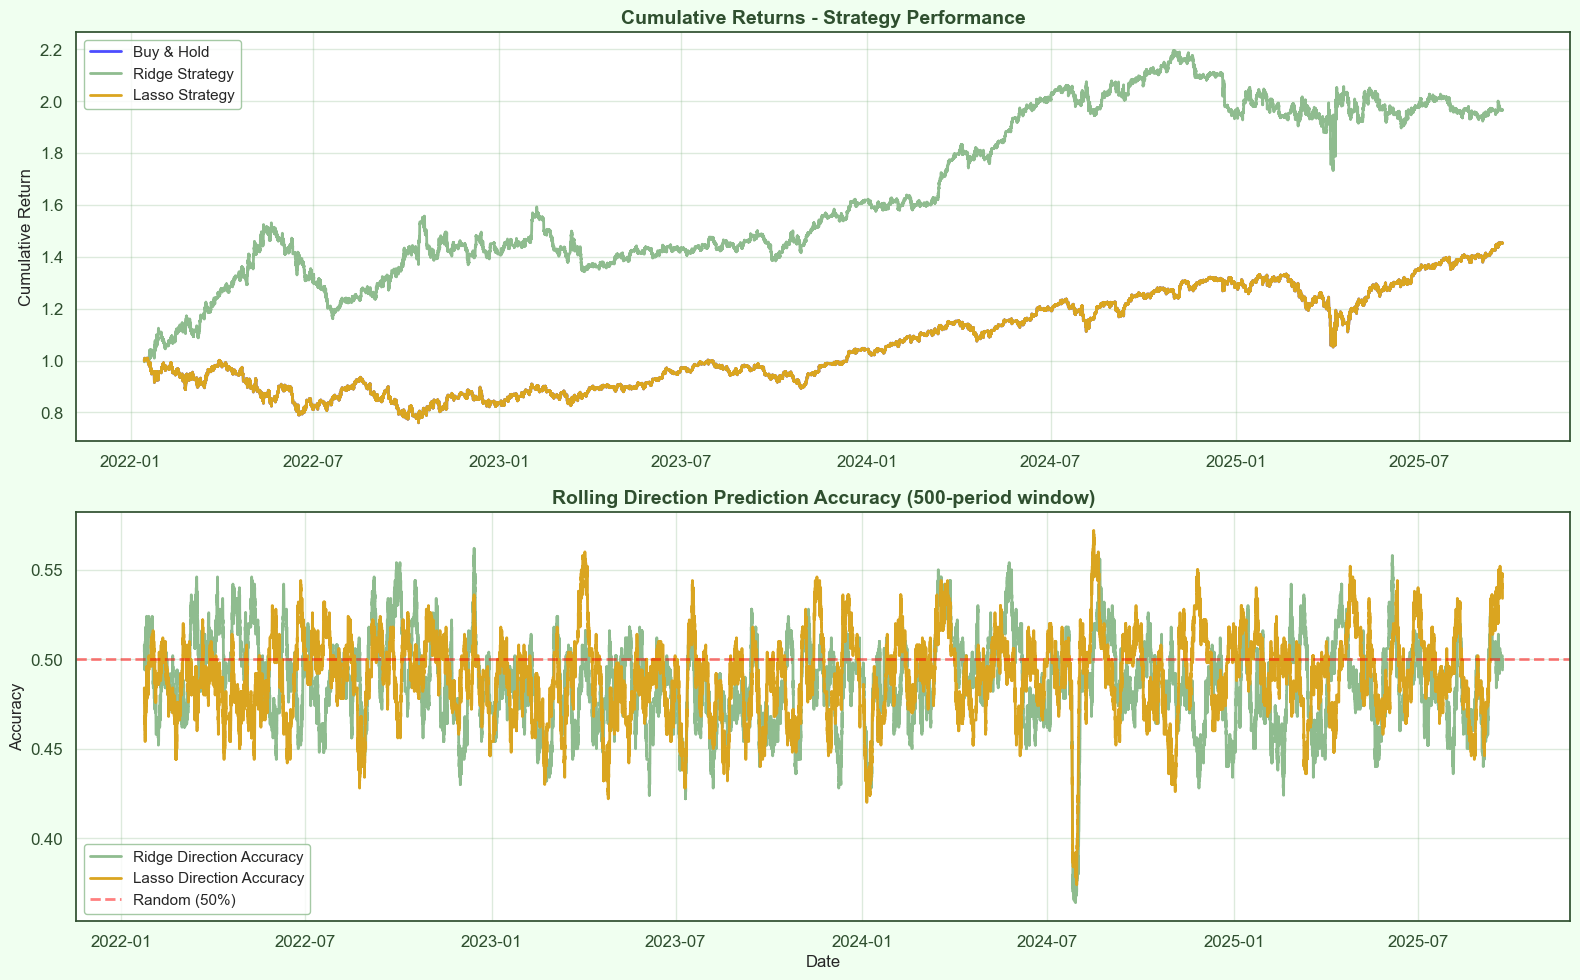

TRADING STRATEGY PERFORMANCE
Buy & Hold Return:           45.31%
Ridge Strategy Return:       96.57%
Lasso Strategy Return:       45.31%

Direction Accuracy:
Ridge:                       48.67%
Lasso:                       49.03%


In [62]:
# Trading strategy simulation: trade based on prediction sign
test_df = pd.DataFrame({
    'actual_return': y_test.values,
    'predicted_return': preds,
    'lasso_predicted': lasso_preds
}, index=y_test.index)

# Strategy: go long if predicted return > 0, short if < 0
test_df['ridge_strategy_return'] = np.where(test_df['predicted_return'] > 0, 
                                            test_df['actual_return'], 
                                            -test_df['actual_return'])
test_df['lasso_strategy_return'] = np.where(test_df['lasso_predicted'] > 0,
                                            test_df['actual_return'],
                                            -test_df['actual_return'])

# Cumulative returns
test_df['buy_hold_cumulative'] = (1 + test_df['actual_return']).cumprod()
test_df['ridge_cumulative'] = (1 + test_df['ridge_strategy_return']).cumprod()
test_df['lasso_cumulative'] = (1 + test_df['lasso_strategy_return']).cumprod()

# Plot
fig, axes = plt.subplots(2, 1, figsize=(16, 10))

# Cumulative returns
axes[0].plot(test_df.index, test_df['buy_hold_cumulative'], 
            label='Buy & Hold', linewidth=2, color='blue', alpha=0.7)
axes[0].plot(test_df.index, test_df['ridge_cumulative'], 
            label='Ridge Strategy', linewidth=2, color=AI_COLORS['primary'])
axes[0].plot(test_df.index, test_df['lasso_cumulative'], 
            label='Lasso Strategy', linewidth=2, color=AI_COLORS['gold'])
axes[0].set_ylabel('Cumulative Return', fontsize=12)
axes[0].set_title('Cumulative Returns - Strategy Performance', fontsize=14, fontweight='bold')
axes[0].legend(fontsize=11)
axes[0].grid(alpha=0.3)

# Prediction accuracy over time (rolling)
test_df['ridge_direction_correct'] = (np.sign(test_df['predicted_return']) == np.sign(test_df['actual_return'])).astype(int)
test_df['lasso_direction_correct'] = (np.sign(test_df['lasso_predicted']) == np.sign(test_df['actual_return'])).astype(int)
test_df['ridge_rolling_accuracy'] = test_df['ridge_direction_correct'].rolling(500).mean()
test_df['lasso_rolling_accuracy'] = test_df['lasso_direction_correct'].rolling(500).mean()

axes[1].plot(test_df.index, test_df['ridge_rolling_accuracy'], 
            label='Ridge Direction Accuracy', linewidth=2, color=AI_COLORS['primary'])
axes[1].plot(test_df.index, test_df['lasso_rolling_accuracy'],
            label='Lasso Direction Accuracy', linewidth=2, color=AI_COLORS['gold'])
axes[1].axhline(0.5, color='red', linestyle='--', linewidth=2, alpha=0.5, label='Random (50%)')
axes[1].set_xlabel('Date', fontsize=12)
axes[1].set_ylabel('Accuracy', fontsize=12)
axes[1].set_title('Rolling Direction Prediction Accuracy (500-period window)', 
                 fontsize=14, fontweight='bold')
axes[1].legend(fontsize=11)
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

# Summary statistics
print("="*70)
print("TRADING STRATEGY PERFORMANCE")
print("="*70)
print(f"Buy & Hold Return:        {(test_df['buy_hold_cumulative'].iloc[-1] - 1)*100:>8.2f}%")
print(f"Ridge Strategy Return:    {(test_df['ridge_cumulative'].iloc[-1] - 1)*100:>8.2f}%")
print(f"Lasso Strategy Return:    {(test_df['lasso_cumulative'].iloc[-1] - 1)*100:>8.2f}%")
print(f"\nDirection Accuracy:")
print(f"Ridge:                    {test_df['ridge_direction_correct'].mean()*100:>8.2f}%")
print(f"Lasso:                    {test_df['lasso_direction_correct'].mean()*100:>8.2f}%")

# Findings

Ready for your analysis and interpretation of the return prediction results!